<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-准备数据" data-toc-modified-id="1-准备数据-1">1 准备数据</a></span><ul class="toc-item"><li><span><a href="#1.1-数据加载" data-toc-modified-id="1.1-数据加载-1.1">1.1 数据加载</a></span></li><li><span><a href="#1.2-类别特征进行one-hot编码" data-toc-modified-id="1.2-类别特征进行one-hot编码-1.2">1.2 类别特征进行one-hot编码</a></span></li></ul></li><li><span><a href="#2-EDA" data-toc-modified-id="2-EDA-2">2 EDA</a></span><ul class="toc-item"><li><span><a href="#2.1-检查目标值的不均衡情况" data-toc-modified-id="2.1-检查目标值的不均衡情况-2.1">2.1 检查目标值的不均衡情况</a></span></li><li><span><a href="#2.2-ProfileReport生成数据分析报告" data-toc-modified-id="2.2-ProfileReport生成数据分析报告-2.2">2.2 ProfileReport生成数据分析报告</a></span></li></ul></li><li><span><a href="#3-指定特征值和目标值" data-toc-modified-id="3-指定特征值和目标值-3">3 指定特征值和目标值</a></span></li><li><span><a href="#4-拆分数据集" data-toc-modified-id="4-拆分数据集-4">4 拆分数据集</a></span></li><li><span><a href="#5-GridSearchCV参数调优" data-toc-modified-id="5-GridSearchCV参数调优-5">5 GridSearchCV参数调优</a></span></li><li><span><a href="#6-可视化最佳模型预测结果的混淆矩阵" data-toc-modified-id="6-可视化最佳模型预测结果的混淆矩阵-6">6 可视化最佳模型预测结果的混淆矩阵</a></span></li></ul></div>

信用卡违约率检测    
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset    
对信用卡使用数据进行建模，预测用户是否下个月产生违约 => 分类问题    
机器学习算法有很多，比如SVM、决策树、随机森林和KNN => 该使用哪个模型    
可以使用GridSearchCV工具，找到每个分类器的最优参数和最优分数，最终找到最适合数据集的分类器和此分类器的参数    

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# 1 准备数据
## 1.1 数据加载

In [2]:
# 数据加载
data = pd.read_csv("./UCI_Credit_Card.csv")
print(data.shape)
data.describe()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 1.2 类别特征进行one-hot编码

In [3]:
# 去掉ID列
data = data.drop(columns=['ID'])
# 将3个类别特征进行one-hot编码
data = pd.get_dummies(data, columns=['SEX', 'EDUCATION', 'MARRIAGE'])
data.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,0,1,0,0,0,0,0,1,0,0
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,0,1,0,0,0,0,0,0,1,0
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,0,1,0,0,0,0,0,0,1,0
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,0,1,0,0,0,0,0,1,0,0
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,0,1,0,0,0,0,0,1,0,0


# 2 EDA

## 2.1 检查目标值的不均衡情况

Text(0.5, 1.0, 'Credict Card Target Values \n(Default = 0, Not Default = 1)')

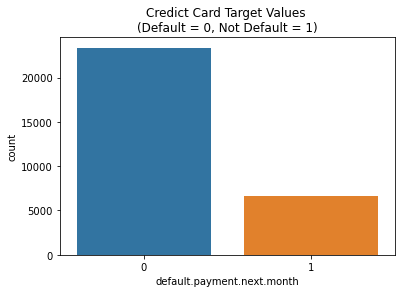

In [4]:
ax = sns.countplot(
    x="default.payment.next.month",
    data=data,
)

plt.title("Credict Card Target Values \n(Default = 0, Not Default = 1)")


In [5]:
data["default.payment.next.month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

不平衡的情况不严重。

## 2.2 ProfileReport生成数据分析报告

In [6]:
# 如果report.html不存在，则生成数据分析报告文件
EXIST_PATH = "report.html"
if not os.path.exists(EXIST_PATH):
    report = pp.ProfileReport(data)
    report.to_file(EXIST_PATH)

# 3 指定特征值和目标值

In [7]:
target = data["default.payment.next.month"].values
cols = data.columns.tolist()
cols.remove("default.payment.next.month")

features = data[cols].values
features

array([[ 2.0e+04,  2.4e+01,  2.0e+00, ...,  1.0e+00,  0.0e+00,  0.0e+00],
       [ 1.2e+05,  2.6e+01, -1.0e+00, ...,  0.0e+00,  1.0e+00,  0.0e+00],
       [ 9.0e+04,  3.4e+01,  0.0e+00, ...,  0.0e+00,  1.0e+00,  0.0e+00],
       ...,
       [ 3.0e+04,  3.7e+01,  4.0e+00, ...,  0.0e+00,  1.0e+00,  0.0e+00],
       [ 8.0e+04,  4.1e+01,  1.0e+00, ...,  1.0e+00,  0.0e+00,  0.0e+00],
       [ 5.0e+04,  4.6e+01,  0.0e+00, ...,  1.0e+00,  0.0e+00,  0.0e+00]])

# 4 拆分数据集

In [8]:
# 超参数
RANDOM_STATE = 30
TEST_SIZE = 0.3

In [9]:
# 30% 作为测试集
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    random_state=RANDOM_STATE,
                                                    test_size=TEST_SIZE)

# 5 GridSearchCV参数调优

In [10]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Not Default', 'Default']

def my_plot_confusion_matrix(classifier, x_test, y_test, class_names):
    titles_options = [("Confusion matrix, without normalization", None),
#                       ("Normalized confusion matrix", 'true')
                     ]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, x_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        
        print(disp.confusion_matrix)

In [11]:
def my_grid_search_cv(pipeline_, x_train, x_test, y_train, y_test, model_param_grid , score=['accuracy']):
    """对具体的分类器进行GridSearchCV参数调优"""
#     # 参数cv=None代表5折交叉验证
    grid_search = GridSearchCV(estimator=pipeline_, param_grid=model_param_grid)
    grid_search.fit(x_train, y_train)

    print(f"模型名称：{model_name}")
    print("GridSearchCV的最优参数为：{}".format(grid_search.best_params_))
    print("GridSearchCV的最优准确率：{}".format(grid_search.best_score_))

    y_pred = grid_search.predict(x_test)
    for c in score:
        if c == 'accuracy':
            print("准确率： %.4f" % accuracy_score(y_test, y_pred))
        elif c == 'auc':
            y_pro = grid_search.predict_proba(x_test)[:, 1]
            print("AUC： %.4f" % roc_auc_score(y_test, y_pro))
        
    return grid_search.best_estimator_

In [12]:
# 构造分类器
classifiers = [
    SVC(probability=True, random_state=RANDOM_STATE),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    LogisticRegression(random_state=RANDOM_STATE),
]
# 分类器名称
classifier_names = [
    "svc", "decisiontreeclassifier", "randomforestclassifier",
    "kneighborsclassifier", "gbdt", "logisticregression"
]

# 分类器参数
# 得到SVC的最优参数：{'svc__C': 10.0, 'svc__gamma': 0.01}
# classifier_param_grid = [
#     {
#         'svc__C': np.logspace(-1, 1, 3),  # array([ 0.1,  1. , 10. ])
#         'svc__gamma': np.logspace(-2, 1, 4),  # array([ 0.01,  0.1 ,  1.  , 10.  ])
#     },
#     {
#         'decisiontreeclassifier__max_depth': [6, 9, 11]
#     },
#     {
#         'randomforestclassifier__n_estimators': [3, 5, 6]
#     },
#     {
#         'kneighborsclassifier__n_neighbors': [4, 6, 8]
#     },
#     {
#         "gbdt__learning_rate": [0.5, 0.1, 0.01, 0.001],
#         "gbdt__n_estimators": np.arange(100, 501, 100)
#     },
#     {
#         "logisticregression__max_iter": [300]
#     }
# ]


classifier_param_grid = [
    {
        'svc__C': [10.],  
        'svc__gamma': [0.01],  
    },
    {
        'decisiontreeclassifier__max_depth': [6, 9, 11]
    },
    {
        'randomforestclassifier__n_estimators': [3, 5, 6]
    },
    {
        'kneighborsclassifier__n_neighbors': [4, 6, 8]
    },
    {
        "gbdt__learning_rate": [0.5, 0.1, 0.01, 0.001],
        "gbdt__n_estimators": np.arange(100, 501, 100)
    },
    {
        "logisticregression__max_iter": [300]
    }
]


In [13]:
best_models = []

for model, model_name, model_param_grid in zip(classifiers, classifier_names,
                                               classifier_param_grid):
    pipe = Pipeline([('scaler', StandardScaler()), (model_name, model)],
                    verbose=False)
    best_model = my_grid_search_cv(pipe,
                                   x_train,
                                   x_test,
                                   y_train,
                                   y_test,
                                   model_param_grid,
                                   score=['accuracy', 'auc'])
    best_models.append(best_model)

模型名称：svc
GridSearchCV的最优参数为：{'svc__C': 10.0, 'svc__gamma': 0.01}
GridSearchCV的最优准确率：0.8183333333333331
准确率： 0.8213
AUC： 0.7159
模型名称：decisiontreeclassifier
GridSearchCV的最优参数为：{'decisiontreeclassifier__max_depth': 6}
GridSearchCV的最优准确率：0.8179047619047619
准确率： 0.8182
AUC： 0.7563
模型名称：randomforestclassifier
GridSearchCV的最优参数为：{'randomforestclassifier__n_estimators': 6}
GridSearchCV的最优准确率：0.7958095238095239
准确率： 0.8013
AUC： 0.7049
模型名称：kneighborsclassifier
GridSearchCV的最优参数为：{'kneighborsclassifier__n_neighbors': 8}
GridSearchCV的最优准确率：0.8023809523809524
准确率： 0.8107
AUC： 0.7098
模型名称：gbdt
GridSearchCV的最优参数为：{'gbdt__learning_rate': 0.01, 'gbdt__n_estimators': 300}
GridSearchCV的最优准确率：0.8198095238095238
准确率： 0.8231
AUC： 0.7751
模型名称：logisticregression
GridSearchCV的最优参数为：{'logisticregression__max_iter': 300}
GridSearchCV的最优准确率：0.8102380952380951
准确率： 0.8142
AUC： 0.7212


从得到的模型结果中，可以看出：GBDT的准确率和AUC均高于其他模型。

# 6 可视化最佳模型预测结果的混淆矩阵

[[6718  346]
 [1246  690]]


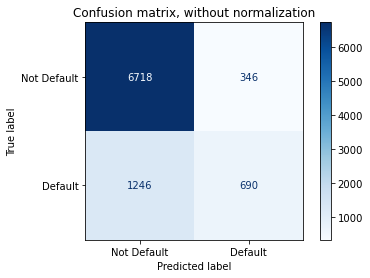

In [15]:
my_plot_confusion_matrix(best_models[-2], x_test, y_test, class_names)



从结果来看，违约的用户中只识别出了约三分之一，仍有优化空间。